In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.data.all import *
from local.vision.core import *
from local.notebook.showdoc import show_doc
from local.audio.core import *
from local.audio.augment import *
from local.learner import *
from local.vision.models.xresnet import *
from local.metrics import *

In [ ]:
p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')
x = AudioGetter("", recurse=True, folders=None)
files = x(p)
original_aud = AudioItem.create(files[0])

In [ ]:
a2s = AudioToSpec(n_fft = 1024, hop_length=256)

In [ ]:
original_spec = a2s(original_aud)

In [ ]:
type(original_spec[0])

local.audio.core.AudioSpectrogram

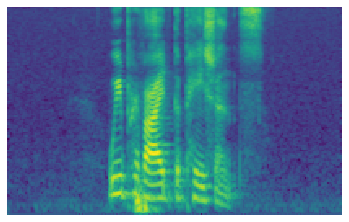

In [ ]:
original_spec.show()

In [ ]:
original_spec.n_fft

1024

# End-to-End Example

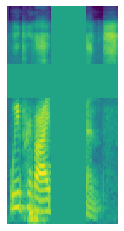

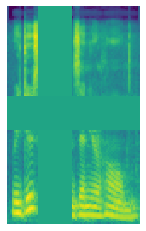

In [ ]:
items = get_audio_files(p)
oa = OpenAudio(items)
preprocesses = [oa, RemoveSilence("trim"), Resample(22050),]
augments = [AudioToSpec(n_fft=1048), MaskTime(), MaskFreq()]
functions = preprocesses + augments
pipe = Pipeline(functions, as_item=True)
for i in range(2): pipe.show(pipe(i))

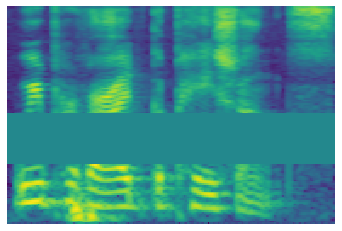

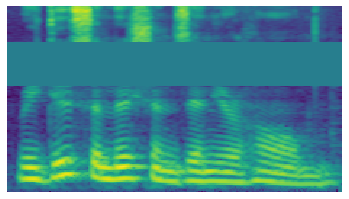

In [ ]:
oa = OpenAudio(items)
preprocesses = [oa, RemoveSilence("trim"), Resample(16000),]
short_hop_mel = MelSpectrogramConfig(hop_length=128, n_fft=1024)
augments = [AudioToSpec.from_cfg(short_hop_mel), MaskFreq(size=30)]
functions = preprocesses + augments
pipe = Pipeline(functions, as_item=True)
for i in range(2): pipe.show(pipe(i))

<div class='alert alert-block alert-warning'><strong>Warning:</strong>By default AudioToSpec will use the default arguments of the specified _GenSpec() function (currently wraps torchaudio.transforms.MelSpectrogram). In that function the defaults are awful, and hop_length defaults to None. We don't currently pass along arguments whose value is None to be stored as attributes of the AudioSpectrogram object, so if no hop_length is specified, CropTime won't work. Not sure the best fix right now so I'm leaving it as an open issue. Likely we will override MelSpectrograms default hop_length, because having a default hop_length is important because without it you cant interpret the x-axis of a spectrogram. The other option is storing a duration attribute directly in the spectrogram. This would allow us to have access to the scale of the x-axis without a hop, and we could avoid the repetition of calculating time duration from hop/sr/samples.

First example below demonstrates the problem. No hop_length is specified for AudioToSpec -> error: AudioSpectrogram object has no attribute hop_length

Second example demonstrates a working version by passing a hop_length
</div>

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav


TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

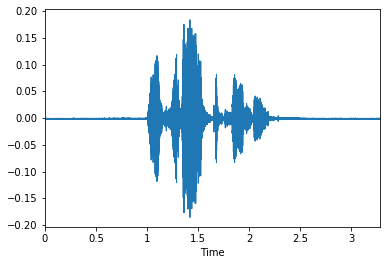

In [ ]:
labeler = lambda x: str(x).split('/')[-1][:5]
tfms = [[AudioItem.create, Resample(8000)], [labeler]]
items = get_audio_files(p)

tds = TfmdDS(items, tfms)
tds.show(tds[0])
tdl = TfmdDL(tds, bs=8, after_item=[AudioToSpec(), CropTime(1000), MaskTime(), MaskFreq()])

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav


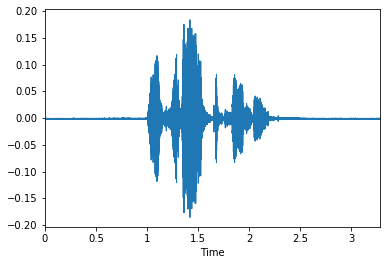

In [ ]:
labeler = lambda x: str(x).split('/')[-1][:5]
tfms = [[AudioItem.create, Resample(8000)], [labeler]]
items = get_audio_files(p)

tfds = TfmdDS(items, tfms)
tfds.show(tfds[0])
bs = 8
tfdl = TfmdDL(tfds, bs=bs, after_item=[AudioToSpec(hop_length=256), CropTime(1000), MaskTime(), MaskFreq()])

In [ ]:
t = tfdl.one_batch()
print(len(t[0]), "tensors with shapes", [ten.shape for ten in t[0]])
print("labels", t[1])

8 tensors with shapes [torch.Size([1, 128, 31]), torch.Size([1, 128, 31]), torch.Size([1, 128, 31]), torch.Size([1, 128, 31]), torch.Size([1, 128, 31]), torch.Size([1, 128, 31]), torch.Size([1, 128, 31]), torch.Size([1, 128, 31])]
labels ('f0004', 'm0002', 'f0003', 'f0001', 'f0005', 'm0005', 'f0005', 'f0005')


<div class = "alert alert-block alert-info"><strong>TO-DO:</strong> `decode_batch` and `show_batch` are causing recursion errors in the following two cells</div>


In [ ]:
#tfdl.show_batch(max_n=4)

In [ ]:
# batch = tfdl.one_batch()
# test_eq(len(batch[0]), bs)
# test_eq(len(batch[1]), bs)
# tfdl.decode_batch(batch)

## Datablock and Basic End to End Training

In [ ]:
auds = DataBlock(ts=(AudioItem, Category), 
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 get_y=lambda x: str(x).split('/')[-1][:5])

In [ ]:
cats = [y for _,y in auds.datasource(p)]

In [ ]:
#verify categories are being correctly assigned
min(cats), max(cats)

(0, 9)

<div class = "alert alert-block alert-warning">Because we haven't adjusted the standard learner to handle 1 channel input, we have to just stack the spectrograms to 3 channels using expand to see if we can get an actual end-to-end training example</div>

In [ ]:
def Stack3Channels():
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        sg = spectro.clone().expand(3, -1, -1)
        return AudioSpectrogram.create(sg, settings=spectro.settings)
    return _inner

In [ ]:
p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')
a2s = AudioToSpec(n_fft = 1024, hop_length=256)
crop_2000ms = CropTime(2000)
tfms = Pipeline([a2s, crop_2000ms, Stack3Channels()], as_item=True)
dbunch = auds.databunch(p, ds_tfms=tfms, bs=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


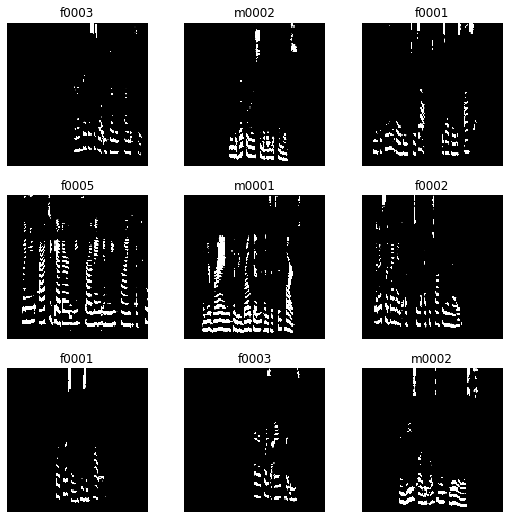

In [ ]:
dbunch.show_batch(max_n=9)

In [ ]:
dbunch.one_batch()[0].shape

torch.Size([64, 3, 128, 125])

In [ ]:
learn = Learner(xresnet18(), 
                dbunch, 
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])

In [ ]:
learn.fit(10, lr=3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.788270,1.331033,0.634115,00:10
1,1.099790,0.888145,0.778646,00:07
2,0.807580,0.697756,0.816406,00:07
3,0.645195,0.605805,0.847656,00:07
4,0.525127,0.502725,0.881510,00:07
5,0.448937,0.446871,0.891927,00:07
6,0.387721,0.374235,0.917969,00:07
7,0.338162,0.327085,0.932292,00:07
8,0.296471,0.284726,0.927083,00:07
9,0.265549,0.278162,0.938802,00:07


In [ ]:
# sg_cfg = SpectrogramConfig(hop=256)
# cfg._sr = 16000
# pipe = Pipeline([oa, RemoveSilence(cfg), AudioToSpec(cfg), MaskTime(num_masks=2, size=10), MaskFreq(val=0)], as_item=True)

In [ ]:
# for i in range(1): pipe.show(pipe(i))

## Cropping signal instead of Spectrogram so that we can move on to GPU transforms

In [ ]:
auds = DataBlock(ts=(AudioItem, Category), 
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 get_y=lambda x: str(x).split('/')[-1][:5])

In [ ]:
auds.datasource(p)[0]

((tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.5259e-04,
           -6.1035e-05, -1.8311e-04]]),
  16000,
  PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav')),
 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


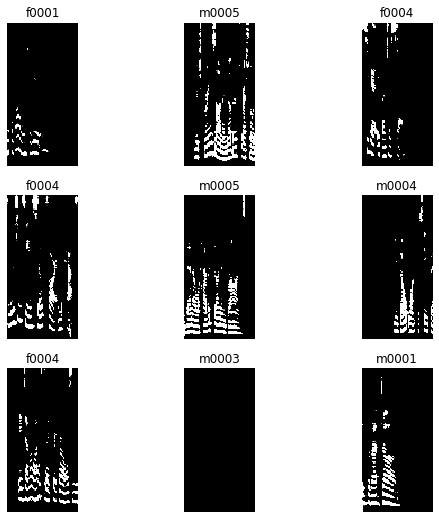

In [ ]:
p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')
cropsig_2000ms = CropSignal(2000)
a2s2 = AudioToSpec(n_fft=1024, hop_length=128)
ds_tfms = Pipeline([cropsig_2000ms, a2s2, Stack3Channels()], as_item=True)
dl_tfms = Pipeline([], as_item=True)
dbunch = auds.databunch(p, ds_tfms=ds_tfms, dl_tfms=dl_tfms, bs=64)
dbunch.show_batch(max_n=9)

<div class = "alert alert-block alert-warning"><strong>Bug: </strong>Cropsig 2000ms is giving us an image that is only 63 pixels wide, crop spectro 2000ms is giving us one that is 125 pixels wide. Odd that it is almost 2x exactly (might be exact)</div>

Let's do math, 2000ms = 2s = 32000 samples @ 16khz. Hop is 256 so expected width is 32000/256 = 125 so the CropTime for spectros is right and the one for signal is wrong by half, why? Earlier testing verified it was cropping to right number of samples 16000/32000/80000 for 1000ms 2000ms 5000ms @ 16khz. If the pipeline is a2s -> CropTime(spectro) it changes when we alter the hop_length of the a2s transform, but it doesn't when we go CropSignal(sig) -> a2s, why? Note that changing the duration for CropSignal does work and change the end images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


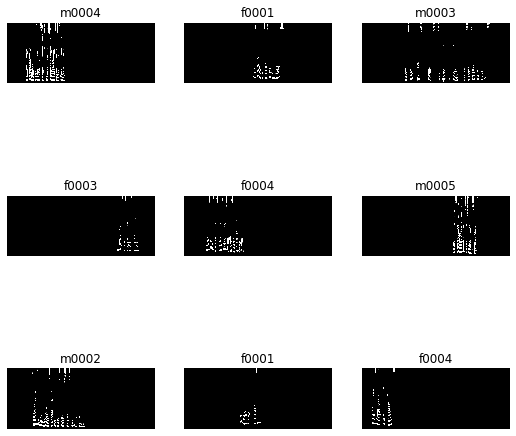

In [ ]:
p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')
a2s = AudioToSpec(n_fft = 1024, hop_length=64)
cropsig_10000ms = CropSignal(10000)
tfms = Pipeline([cropsig_10000ms, a2s, Stack3Channels()], as_item=True)
dbunch = auds.databunch(p, ds_tfms=tfms, bs=64)
dbunch.show_batch(max_n=9)

In [ ]:
dbunch.one_batch()[0].shape

torch.Size([64, 3, 128, 313])

In [ ]:
learn = Learner(xresnet18(), 
                dbunch, 
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])

In [ ]:
learn.fit(10, lr=3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.137600,1.809379,0.539062,00:16
1,1.516847,1.352859,0.630208,00:16
2,1.222708,1.106284,0.695312,00:16
3,1.042501,0.976586,0.733073,00:16
4,0.916507,0.856727,0.743490,00:16
5,0.819105,0.758444,0.795573,00:16
6,0.736252,0.712448,0.824219,00:16
7,0.668091,0.617474,0.876302,00:16
8,0.612341,0.632551,0.843750,00:16
9,0.551272,0.549931,0.871094,00:16


In [ ]:
# End-to-End Example

items = get_audio_files(p)
oa = OpenAudio(items)
preprocesses = [oa, RemoveSilence("trim"), Resample(22050),]
augments = [AudioToSpec(n_fft=1048), MaskTime(), MaskFreq()]
functions = preprocesses + augments
pipe = Pipeline(functions, as_item=True)
for i in range(2): pipe.show(pipe(i))

oa = OpenAudio(items)
preprocesses = [oa, RemoveSilence("trim"), Resample(16000),]
short_hop_mel = MelSpectrogramConfig(hop_length=128, n_fft=1024)
augments = [AudioToSpec.from_cfg(short_hop_mel), MaskFreq(size=30)]
functions = preprocesses + augments
pipe = Pipeline(functions, as_item=True)
for i in range(2): pipe.show(pipe(i))

<div class='alert alert-block alert-warning'><strong>Warning:</strong>By default AudioToSpec will use the default arguments of the specified _GenSpec() function (currently wraps torchaudio.transforms.MelSpectrogram). In that function the defaults are awful, and hop_length defaults to None. We don't currently pass along arguments whose value is None to be stored as attributes of the AudioSpectrogram object, so if no hop_length is specified, CropTime won't work. Not sure the best fix right now so I'm leaving it as an open issue. Likely we will override MelSpectrograms default hop_length, because having a default hop_length is important because without it you cant interpret the x-axis of a spectrogram. The other option is storing a duration attribute directly in the spectrogram. This would allow us to have access to the scale of the x-axis without a hop, and we could avoid the repetition of calculating time duration from hop/sr/samples.

First example below demonstrates the problem. No hop_length is specified for AudioToSpec -> error: AudioSpectrogram object has no attribute hop_length

Second example demonstrates a working version by passing a hop_length
</div>

labeler = lambda x: str(x).split('/')[-1][:5]
tfms = [[AudioItem.create, Resample(8000)], [labeler]]
items = get_audio_files(p)

tds = TfmdDS(items, tfms)
tds.show(tds[0])
tdl = TfmdDL(tds, bs=8, after_item=[AudioToSpec(), CropTime(1000), MaskTime(), MaskFreq()])

labeler = lambda x: str(x).split('/')[-1][:5]
tfms = [[AudioItem.create, Resample(8000)], [labeler]]
items = get_audio_files(p)

tfds = TfmdDS(items, tfms)
tfds.show(tfds[0])
bs = 8
tfdl = TfmdDL(tfds, bs=bs, after_item=[AudioToSpec(hop_length=256), CropTime(1000), MaskTime(), MaskFreq()])

t = tfdl.one_batch()
print(len(t[0]), "tensors with shapes", [ten.shape for ten in t[0]])
print("labels", t[1])

<div class = "alert alert-block alert-info"><strong>TO-DO:</strong> `decode_batch` and `show_batch` are causing recursion errors in the following two cells</div>


#tfdl.show_batch(max_n=4)

# batch = tfdl.one_batch()
# test_eq(len(batch[0]), bs)
# test_eq(len(batch[1]), bs)
# tfdl.decode_batch(batch)

## Datablock and Basic End to End Training

auds = DataBlock(ts=(AudioItem, Category), 
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 get_y=lambda x: str(x).split('/')[-1][:5])

cats = [y for _,y in auds.datasource(p)]

#verify categories are being correctly assigned
min(cats), max(cats)

<div class = "alert alert-block alert-warning">Because we haven't adjusted the standard learner to handle 1 channel input, we have to just stack the spectrograms to 3 channels using expand to see if we can get an actual end-to-end training example</div>

def Stack3Channels():
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        sg = spectro.clone().expand(3, -1, -1)
        return AudioSpectrogram.create(sg, settings=spectro.settings)
    return _inner

p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')
a2s = AudioToSpec(n_fft = 1024, hop_length=256)
crop_2000ms = CropTime(2000)
tfms = Pipeline([a2s, crop_2000ms, Stack3Channels()], as_item=True)
dbunch = auds.databunch(p, ds_tfms=tfms, bs=64)

dbunch.show_batch(max_n=9)

dbunch.one_batch()[0].shape

learn = Learner(xresnet18(), 
                dbunch, 
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])

learn.fit(10, lr=3e-2)

# sg_cfg = SpectrogramConfig(hop=256)
# cfg._sr = 16000
# pipe = Pipeline([oa, RemoveSilence(cfg), AudioToSpec(cfg), MaskTime(num_masks=2, size=10), MaskFreq(val=0)], as_item=True)

# for i in range(1): pipe.show(pipe(i))

## Cropping signal instead of Spectrogram so that we can move on to GPU transforms

auds = DataBlock(ts=(AudioItem, Category), 
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 get_y=lambda x: str(x).split('/')[-1][:5])

auds.datasource(p)[0]

p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')
cropsig_2000ms = CropSignal(2000)
a2s2 = AudioToSpec(n_fft=1024, hop_length=128)
ds_tfms = Pipeline([cropsig_2000ms, a2s2, Stack3Channels()], as_item=True)
dl_tfms = Pipeline([], as_item=True)
dbunch = auds.databunch(p, ds_tfms=ds_tfms, dl_tfms=dl_tfms, bs=64)
dbunch.show_batch(max_n=9)

<div class = "alert alert-block alert-warning"><strong>Bug: </strong>Cropsig 2000ms is giving us an image that is only 63 pixels wide, crop spectro 2000ms is giving us one that is 125 pixels wide. Odd that it is almost 2x exactly (might be exact)</div>

Let's do math, 2000ms = 2s = 32000 samples @ 16khz. Hop is 256 so expected width is 32000/256 = 125 so the CropTime for spectros is right and the one for signal is wrong by half, why? Earlier testing verified it was cropping to right number of samples 16000/32000/80000 for 1000ms 2000ms 5000ms @ 16khz. If the pipeline is a2s -> CropTime(spectro) it changes when we alter the hop_length of the a2s transform, but it doesn't when we go CropSignal(sig) -> a2s, why? Note that changing the duration for CropSignal does work and change the end images

p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')
a2s = AudioToSpec(n_fft = 1024, hop_length=64)
cropsig_10000ms = CropSignal(10000)
tfms = Pipeline([cropsig_10000ms, a2s, Stack3Channels()], as_item=True)
dbunch = auds.databunch(p, ds_tfms=tfms, bs=64)
dbunch.show_batch(max_n=9)

dbunch.one_batch()[0].shape

learn = Learner(xresnet18(), 
                dbunch, 
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])

learn.fit(10, lr=3e-2)

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_torch_core.ipynb.
Converted 01b_script.ipynb.
Converted 01c_dataloader.ipynb.
Converted 02_data_transforms.ipynb.
Converted 03_data_pipeline.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_source.ipynb.
Converted 07_vision_core.ipynb.
Converted 08_pets_tutorial.ipynb.
Converted 09_vision_augment.ipynb.
Converted 11_layers.ipynb.
Converted 11a_vision_models_xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 15_callback_hook.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 20_metrics.ipynb.
Converted 21_tutorial_imagenette.ipynb.
Converted 30_text_core.ipynb.
Converted 31_text_data.ipynb.
Converted 32_text_models_awdlstm.ipynb.
Converted 33_text_models_core.ipynb.
Converted 34_callback_rnn.ipynb.
Converted 35_tutorial_wikitext.ipynb.
Conve

NotJSONError: Notebook does not appear to be JSON: ''...